In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
from skimage.transform import resize
from random import shuffle
import pandas as pd
import cv2

from collections import Counter

data_dir = './data'

In [8]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data
traffic_signs_data_dir = "%s/traffic-signs-data" % data_dir
training_file =  '%s/train.p' % traffic_signs_data_dir
validation_file = '%s/valid.p' % traffic_signs_data_dir
testing_file = '%s/test.p' % traffic_signs_data_dir
    
# Load pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [9]:
signnames_pd = pd.read_csv('signnames.csv')
signnames_pd

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [10]:
def signname_val_to_name(signnames_pd, val):
    #print("###", val)
    return signnames_pd[signnames_pd['ClassId'] == val]['SignName'].values[0]

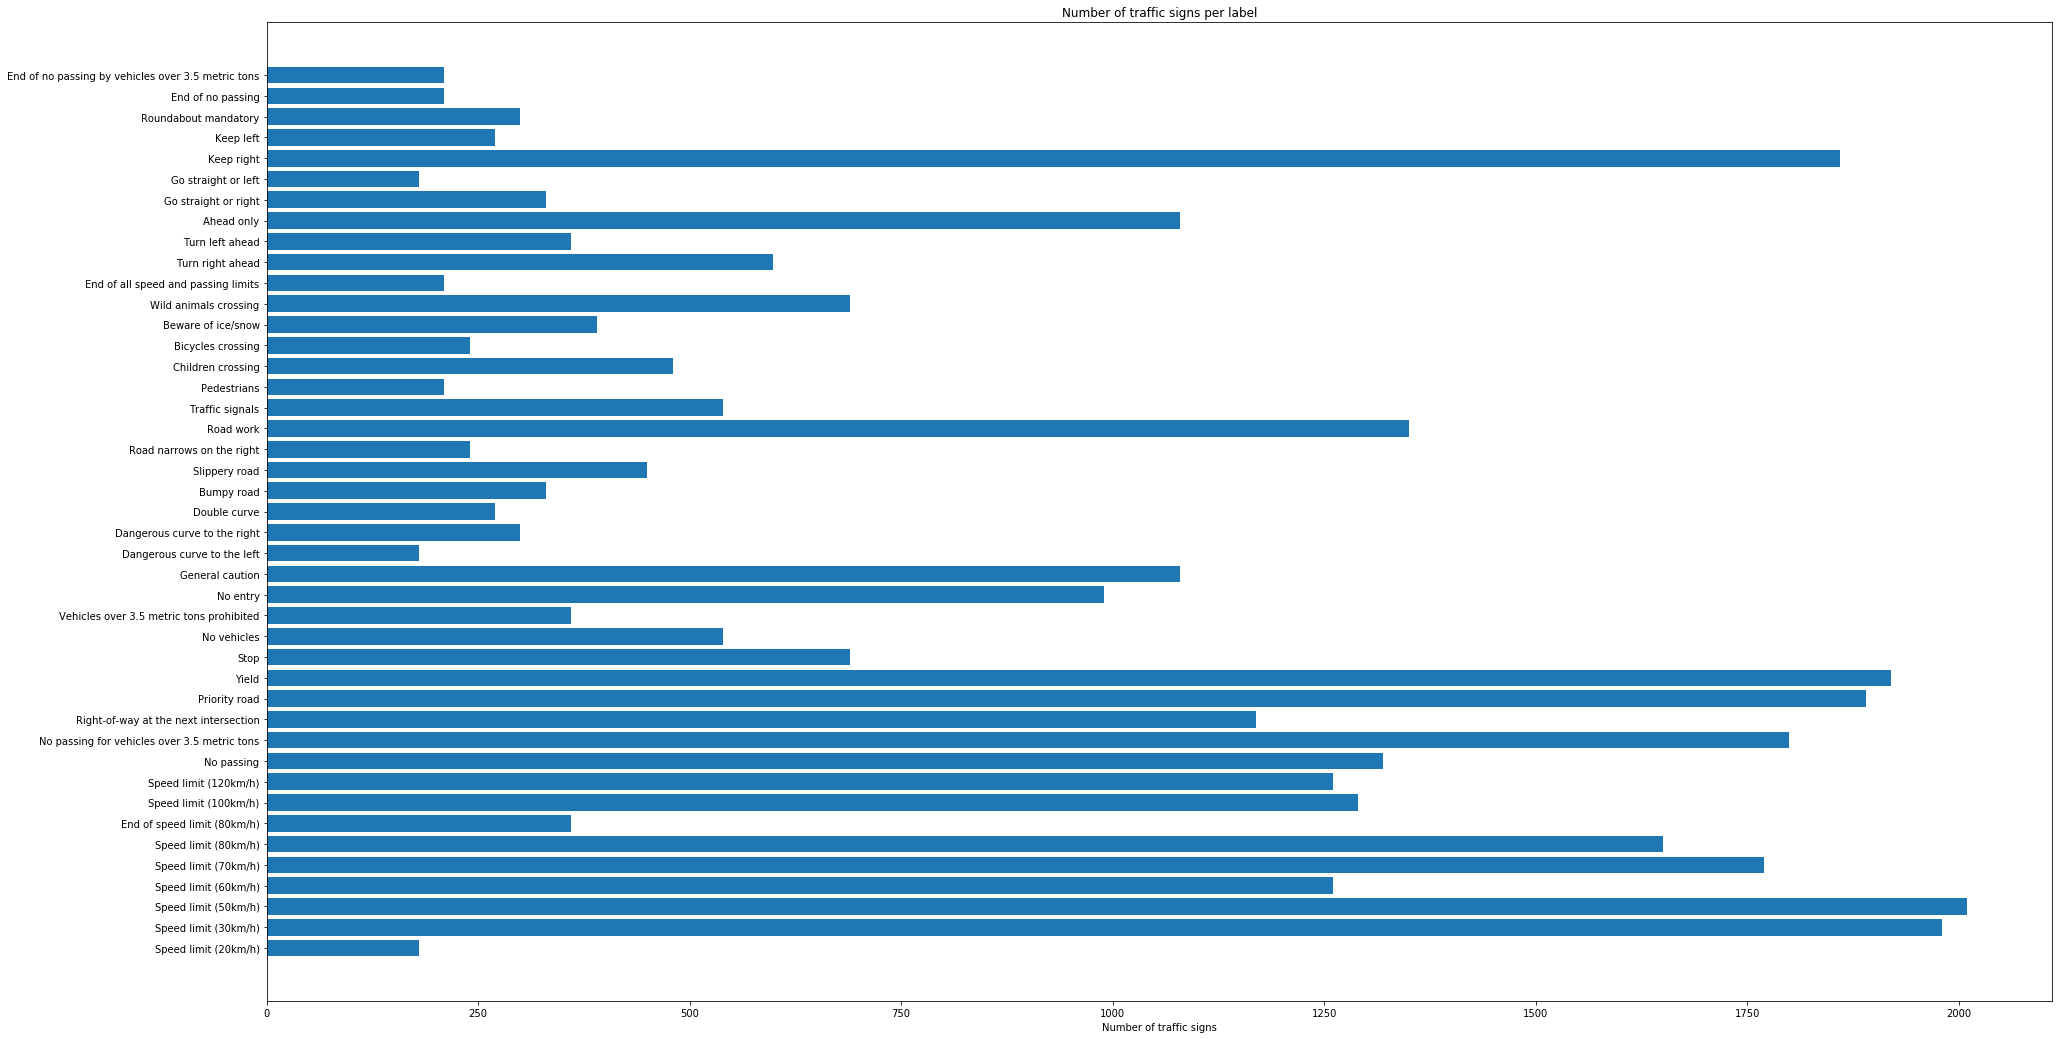

In [11]:
label_cnts = Counter(y_train)

x_vals = [x for x, _ in label_cnts.items()]
y_vals = [y for _, y in label_cnts.items()]    

plt.figure(figsize=(32,18))

plt.barh(x_vals, y_vals)
plt.title("Number of traffic signs per label")
plt.yticks(x_vals, [signname_val_to_name(signnames_pd, val) for val in x_vals])
plt.xlabel('Number of traffic signs')
#plt.ylabel('Label')
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [13]:
mu = 0
sigma = 0.1
alpha=0.05

x = tf.placeholder(tf.float32, (None, 32, 32, 5))

In [14]:
# Layer 1: Convolutional. Input = 32x32x4. Output = 32x32x32.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 5, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME', 
                       name='conv1') + conv1_b
print(conv1.get_shape())

# Leaky ReLU
conv1 = tf.maximum(alpha * conv1, conv1)    

# Pooling. Input = 32x32x32. Output = 16x16x32.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(conv1.get_shape())

(?, 32, 32, 32)
(?, 16, 16, 32)


In [15]:
###
# Layer 2: Convolutional. Output = 16x16x64.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(64))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME', 
                       name='conv2') + conv2_b
print(conv2.get_shape())

# Leaky ReLU
conv2 = tf.maximum(alpha * conv2, conv2)

# Pooling. Input = 16x16x64. Output = 8x8x64.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
###
print(conv2.get_shape())

(?, 16, 16, 64)
(?, 8, 8, 64)


In [16]:
###
# Layer 3: Convolutional. Output = 8x8x64.
conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
conv3_b = tf.Variable(tf.zeros(128))
conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME', name='conv3') + conv3_b
print(conv3.get_shape())

# Leaky ReLU
conv3 = tf.maximum(alpha * conv3, conv3)

# Pooling. Input = 8x8x128. Output = 4x4x128.
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
###  
print(conv3.get_shape())

(?, 8, 8, 128)
(?, 4, 4, 128)


In [17]:
def apply_histogram_equalization(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV).astype(np.uint8)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB).astype(np.uint8)

In [18]:
def display_X_y_images(X, y, signnames_pd, start_idx=0, end_idx=None, columns = 5):
    if end_idx is None:
        end_idx = X.shape[0]
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(num_of_images / columns + 1, columns, _i + 1)
        
        if y[i] == -1:
            title = 'Unlabeled'
        else:
            title = signnames_pd.loc[signnames_pd['ClassId']==y[i]]['SignName'].values[0]
            
        plt.title(title)
        plt.imshow(image)

In [19]:
idxs = [x for x in range(X_train.shape[0])]
shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

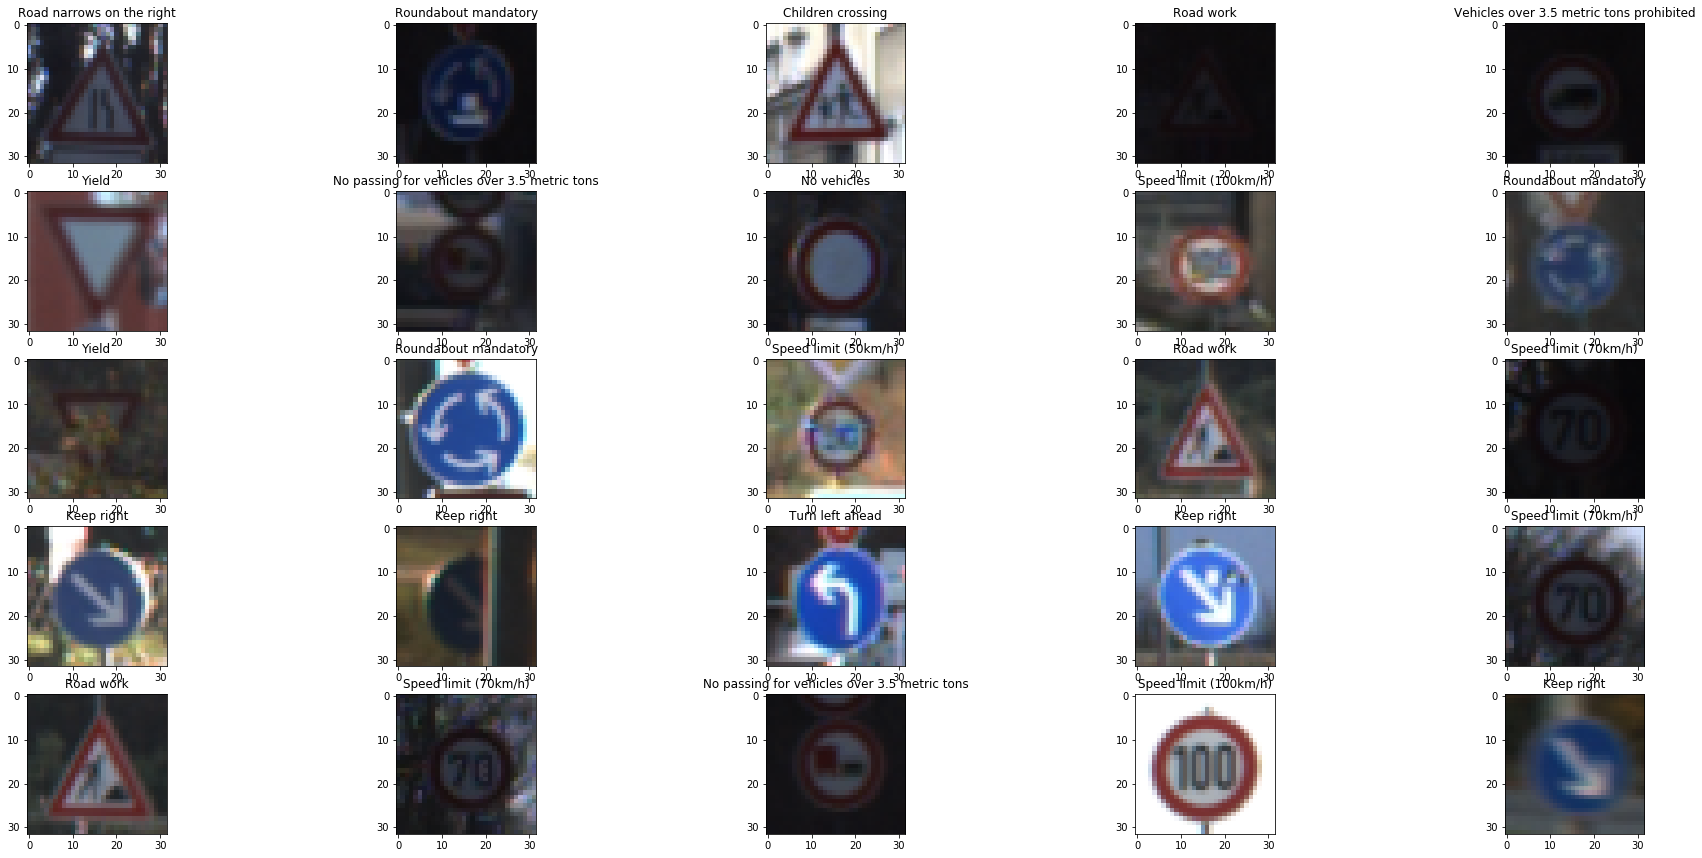

In [20]:
display_X_y_images(X_train, y_train, signnames_pd, 0, 25)

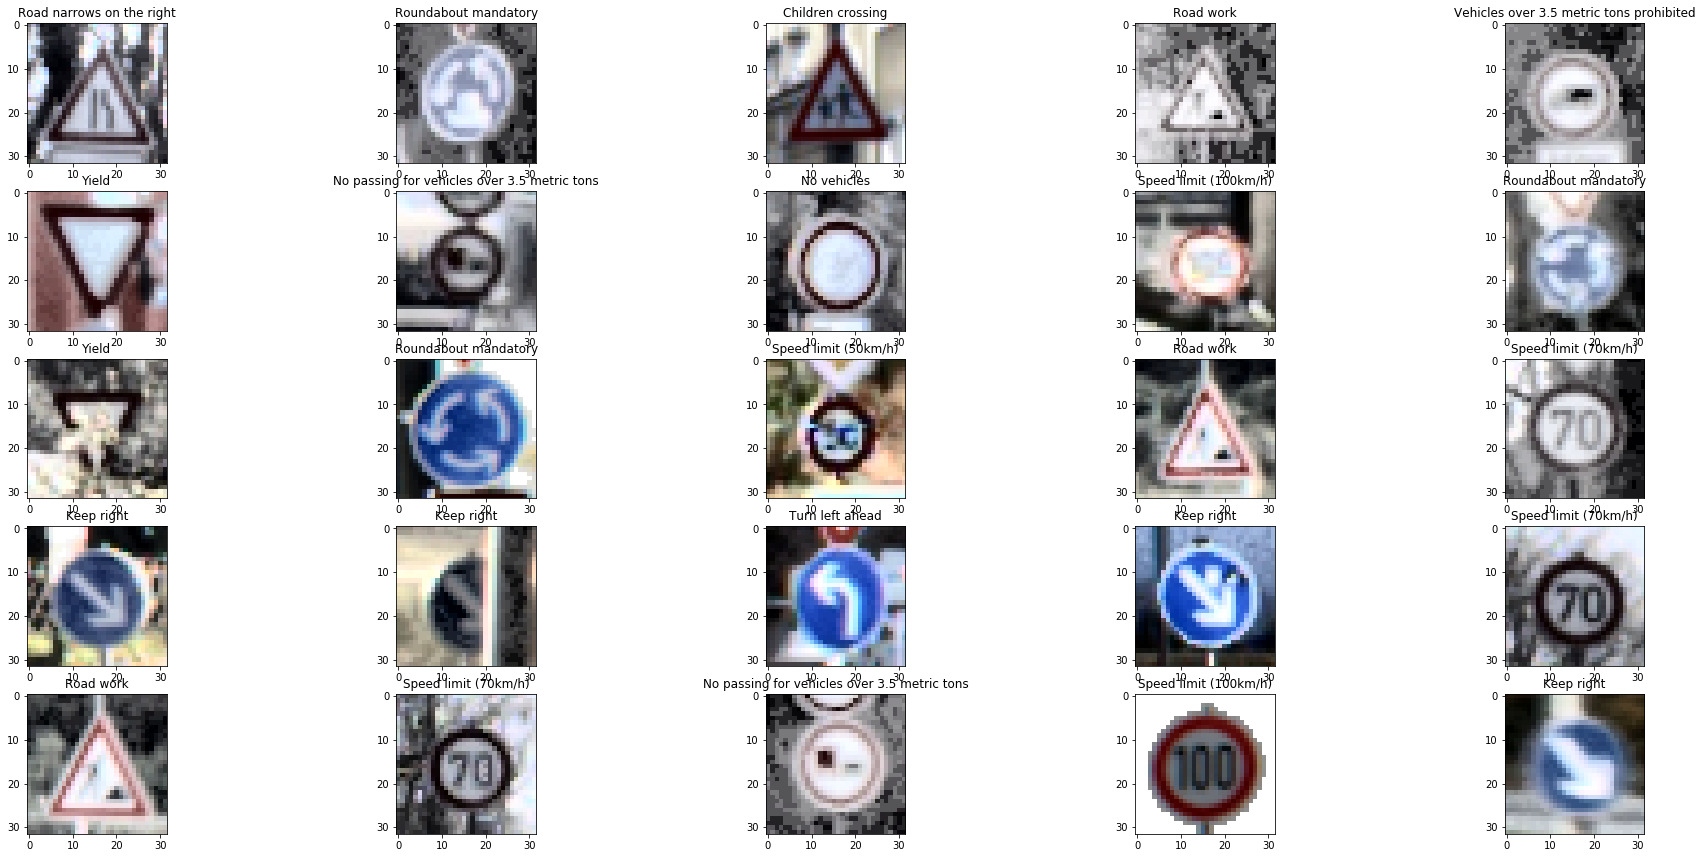

In [21]:
display_X_y_images(np.stack([apply_histogram_equalization(X_train[i]) for i in range(25)]), y_train, signnames_pd, 0, 25)

In [22]:
from collections import Counter

In [78]:
import multiprocessing as mp

In [109]:
class MP(object):
    def __init__(self, worker, input_splitter, output_joiner, num_of_workers=3):
        self.worker = worker
        self.input_splitter = input_splitter
        self.output_joiner = output_joiner
        self.num_of_workers = num_of_workers
        
    def split_input(self, input, n):
        return [(i, input_part) for i, input_part in enumerate(self.input_splitter(input, n))]
    
    def run(self, input):
        pool = mp.Pool()
    
        output = pool.map(self.worker, self.split_input(input, self.num_of_workers))
        
        return self.output_joiner(output, self.num_of_workers)

In [110]:
def my_worker(tuple_val):
    idx, val = tuple_val
    #print(idx, val)
    return {'idx': idx,
           'val': val*2}

In [111]:
def my_input_splitter(input, n):
    for i in range(n):
        yield input[i]

In [117]:
def my_output_joiner(output, n):
    return [output[i]['val'] for i in range(n)]

In [118]:
my_mp = MP(my_worker, my_input_splitter, my_output_joiner, 3)

In [119]:
my_mp.run([0, 1, 2])

[0, 2, 4]